In [1]:
%matplotlib inline

In [2]:
# add repo path
import sys
sys.path.append('/home/gautam_sisodia/gen-purpose-repo/')

In [3]:
import numpy as np
from functools import reduce
from tqdm import tqdm
import pandas as pd
from rl import frozenlake as fl
import matplotlib.pyplot as plt
import seaborn as sns

[2017-11-25 17:19:31,799] Making new env: FrozenLake-v0


In [4]:
plt.style.use('seaborn-darkgrid')

In [5]:
def get_sequences(start = 0, num_seq = 3, seq_len = 3, outer_step = 3, inner_step = 1, inner_step_change = 0):
    seqs = []
    st = start
    curr_inner_step = inner_step
    for _ in range(num_seq):
        seq = []
        entry = st
        for _ in range(seq_len):
            seq.append(entry)
            entry += curr_inner_step
        seqs.append(seq)
        st += outer_step
        curr_inner_step += inner_step_change
    return seqs


In [6]:
class Strategy():
    def __init__(self, pick_action, update_strategy):
        self.pick_action = pick_action
        self.update_strategy = update_strategy        
        
class TicTacToe(object):
    def __init__(self):
        self.board = 9 * [0]
        self.num_moves = 0
        self.game_end = False
        self.winning_sequences = get_sequences() + \
            get_sequences(outer_step = 1, inner_step = 3) + \
            get_sequences(num_seq = 2, outer_step = 2, inner_step = 4, inner_step_change = -2)
                    
    def get_player(self):
        return self.num_moves % 2 + 1
        
    def step(self, action):
        reward = 0
        if action >= 0 and action <= 9:
            position = self.board[action]
            if position == 0:
                self.board[action] = self.get_player()
                if self.check_win():
                    reward = 1
                    self.game_end = True
                if self.check_cats_game():
                    self.game_end = True
            else:
                reward = -1
        self.num_moves += 1
        return reward
    
    def check_cats_game(self):
        return len([i for i in self.board if i == 0]) == 0
    
    def check_seq(self, seq):
        return reduce(
            lambda x, y: x or y, map(
                lambda p: reduce(
                    lambda x, y: x and y, map(
                        lambda x: self.board[x] == p, seq)), [1, 2]))
            
    def check_win(self):
        return reduce(lambda x, y: x or y, map(lambda x: self.check_seq(x), self.winning_sequences))
        
    def switch_perspective(self):
        return [1 if i == 2 else 2 if i == 1 else 0 for i in self.board]
    
    def render(self, print_string = True):
        board_string = "\n".join([" ".join(map(str, line)) for line in np.array(self.board).reshape(3, 3)] +\
            ["player {}'s move".format(self.get_player()) if not self.game_end else "game over"])
        if print_string:
            print(board_string)
        return board_string
    
def print_board(board):
    return  "\n".join([" ".join(map(str, line)) for line in np.array(board).reshape(3, 3)])
        
def board_to_state(board):
    state = 0
    for ind, cell in enumerate(board):
        state += np.power(3, ind) * cell
    return state

def state_to_board(state):
    board = 9 * [0]
    pos = 0
    while state > 0 and pos < 9:
        state, board[pos] = divmod(state, 3)
        pos += 1
    return board

In [7]:
def rand_pick_action(current_state, current_game):
    return np.random.choice(range(9))

def rand_update_strategy(current_state, action, next_state, reward, game_end):
    pass

rand_strategy = Strategy(rand_pick_action, rand_update_strategy)

In [8]:
def human_pick_action(current_state, current_game):
    return int(input(print_board(state_to_board(current_state))))

def human_update_strategy(current_state, action, next_state, reward, game_end):
    pass

human_strategy = Strategy(human_pick_action, human_update_strategy)

In [9]:
def play_game(strategies, game_num = 10000):
    game = TicTacToe()
    game_end = False
    current_game_action_num = 1
    game_string = ""
    while not game_end and current_game_action_num < 20:
        current_state = board_to_state(game.board)
        # move
        player = (current_game_action_num - 1) % 2
        print("player: {}".format(player))
        player_perspective_state = current_state if player == 0 else board_to_state(game.switch_perspective())
        strategy = strategies[player] if len(strategies) == 2 else strategies[0]
        action = strategy.pick_action(player_perspective_state, game_num)
        game.step(action)
        game_end = game.game_end
        current_game_action_num += 1
        game_string += game.render() + "\n"
    return game_string

In [10]:
def run_n_games(num_games, strategies, current_info_dict = False, use_tqdm = True, update = True):
    states_info_dict = {
      "current_game": [],
      "current_game_action_num": [],
      "current_state": [],
      "action": [],
      "next_state": [],
      "reward": [],
      "end_game": []
    } if current_info_dict == False else current_info_dict

    prev_games_played = 0 if current_info_dict == False else len(set(current_info_dict["current_game"]))
    
    loop_list = tqdm(range(1, num_games + 1)) if use_tqdm else range(1, num_games + 1)

    # run the games
    for game_num in loop_list:
        game = TicTacToe()
        game_end = False
        current_state = board_to_state(game.board)
        current_game_action_num = 1
        while not game_end:
            reward = [0, 0]
            # move
            player = (current_game_action_num - 1) % 2
            player_perspective_state = current_state if player == 0 else board_to_state(game.switch_perspective())
            strategy = strategies[player] if len(strategies) == 2 else strategies[0]
            action = strategy.pick_action(player_perspective_state, game_num + prev_games_played)
            reward[player] = game.step(action)
            next_state = board_to_state(game.board)
            game_end = game.game_end
            if update:
                strategy.update_strategy(current_state, action, next_state, reward[player], game_end)

            # add info to dict
            states_info_dict["current_game"].append(game_num + prev_games_played)
            states_info_dict["current_game_action_num"].append(current_game_action_num)
            states_info_dict["current_state"].append(current_state)
            states_info_dict["action"].append(action)
            states_info_dict["next_state"].append(next_state)
            states_info_dict["reward"].append(reward)
            states_info_dict["end_game"].append(game_end)

            # update info
            current_state = next_state
            current_game_action_num += 1

    game_df = pd.DataFrame(states_info_dict)
    # add_state_row_column(game_df, ["current_state", "next_state"])
    return states_info_dict, game_df

def print_game_stats(game_df):
    num_games = max(game_df.current_game)

    # total number of moves?
    print("Total number of moves: {}\nNumber of moves per game: {}".format(
        len(game_df),
        1.0 * len(game_df) / num_games))

    # winning percentage?
    num_games_won = reduce(lambda x, y: np.array(x) + np.array(y), game_df[game_df.end_game].reward)
    print(
        "Total number of games won by player 1: {}\nTotal number of games won by player 2: {}\nPercentage of games won: {}".format(
            num_games_won[0],
            num_games_won[1],
            100.0 * num_games_won.sum() / num_games))

In [11]:
class TicTacToeQTable(Strategy):
    
    def __init__(self, gamma = 0.95, learning_rate = 0.9, damper = 0.0001):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.q_table = np.random.rand(np.power(3, 9), 9) * damper
        
    def pick_action(self, current_state, current_game):
        return np.argmax(self.q_table[current_state,:] + np.random.randn(1, 9) * (1.0 / (current_game + 1)))

    def update_strategy(self, current_state, action, next_state, reward, game_end):
        self.q_table[current_state, action] = self.q_table[current_state, action] -\
          self.learning_rate * (self.q_table[current_state, action] - reward - self.gamma * np.max(self.q_table[next_state, :]))


In [12]:
game = TicTacToe()

In [13]:
game.render()

0 0 0
0 0 0
0 0 0
player 1's move


"0 0 0\n0 0 0\n0 0 0\nplayer 1's move"

In [14]:
game.step(1)
board_to_state(game.board)

3

In [15]:
game.step(0)
game.step(1)
game.step(3)
game.step(2)
game.step(6)

1

In [16]:
game.render()

2 1 1
2 0 0
2 0 0
game over


'2 1 1\n2 0 0\n2 0 0\ngame over'

In [17]:
game.check_win()

True

In [18]:
qtable = TicTacToeQTable()

In [19]:
qtable.q_table.shape

(19683, 9)

In [20]:
rand_games_df = run_n_games(num_games = 10000, strategies = [rand_strategy], use_tqdm = True)[1]

100%|██████████| 10000/10000 [00:18<00:00, 553.21it/s]


In [21]:
print_game_stats(rand_games_df)

Total number of moves: 149980
Number of moves per game: 14.998
Total number of games won by player 1: 5489
Total number of games won by player 2: 3712
Percentage of games won: 92.01


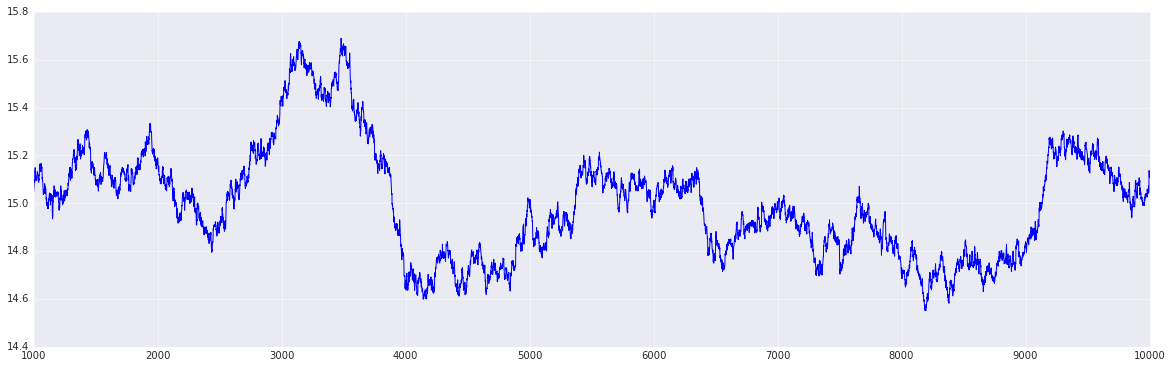

In [22]:
fl.plot_game_length(rand_games_df, 1000)

In [25]:
info_dict =False

In [26]:
info_dict, qtable_games_df = run_n_games(num_games = 10000, current_info_dict = info_dict, strategies = [qtable], use_tqdm = True)

100%|██████████| 10000/10000 [00:10<00:00, 960.96it/s]


In [27]:
print_game_stats(qtable_games_df)

Total number of moves: 77421
Number of moves per game: 7.7421
Total number of games won by player 1: 9345
Total number of games won by player 2: 522
Percentage of games won: 98.67


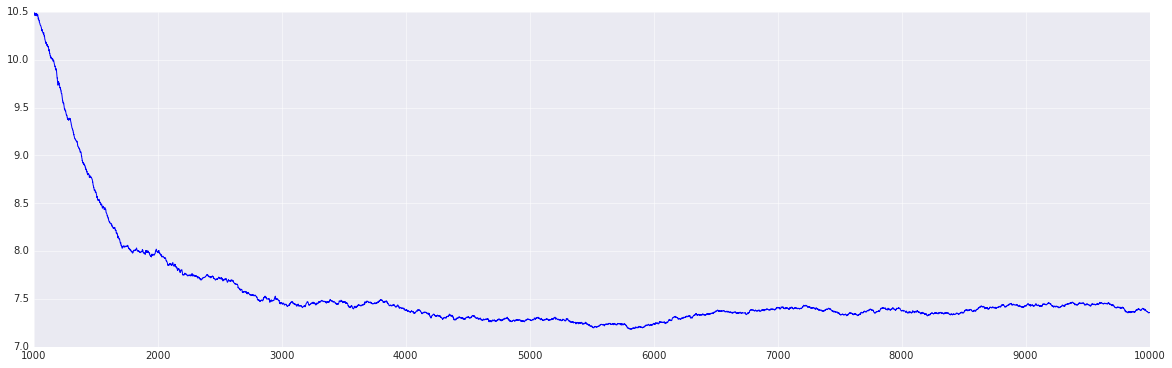

In [28]:
fl.plot_game_length(qtable_games_df, 1000)

In [29]:
qtable_games_df[qtable_games_df.end_game].reward

6        [1, 0]
16       [0, 1]
23       [1, 0]
36       [1, 0]
43       [1, 0]
54       [1, 0]
59       [1, 0]
75       [0, 1]
87       [0, 1]
94       [1, 0]
107      [1, 0]
122      [1, 0]
127      [1, 0]
144      [1, 0]
165      [1, 0]
178      [1, 0]
183      [1, 0]
188      [1, 0]
197      [1, 0]
208      [1, 0]
215      [1, 0]
225      [0, 1]
232      [1, 0]
251      [1, 0]
258      [1, 0]
265      [1, 0]
281      [0, 1]
294      [1, 0]
304      [0, 1]
313      [1, 0]
          ...  
77220    [1, 0]
77225    [1, 0]
77230    [1, 0]
77239    [1, 0]
77246    [1, 0]
77251    [1, 0]
77258    [1, 0]
77263    [1, 0]
77268    [1, 0]
77275    [1, 0]
77284    [1, 0]
77293    [1, 0]
77300    [1, 0]
77307    [1, 0]
77312    [1, 0]
77319    [1, 0]
77326    [1, 0]
77335    [1, 0]
77340    [1, 0]
77347    [1, 0]
77356    [1, 0]
77362    [0, 1]
77371    [1, 0]
77378    [1, 0]
77385    [1, 0]
77394    [1, 0]
77399    [1, 0]
77406    [1, 0]
77411    [1, 0]
77420    [1, 0]
Name: reward, dtype: obj

In [21]:
game_string = play_game(strategies = [qtable])

player: 0
0 0 0
0 0 0
0 0 1
player 2's move
player: 1
0 0 0
0 0 0
0 2 1
player 1's move
player: 0
0 0 1
0 0 0
0 2 1
player 2's move
player: 1
0 0 1
0 0 0
0 2 1
player 1's move
player: 0
0 0 1
0 1 0
0 2 1
player 2's move
player: 1
0 0 1
0 1 0
0 2 1
player 1's move
player: 0
0 0 1
0 1 0
1 2 1
game over


In [22]:
play_game(strategies = [qtable, human_strategy])

player: 0
0 0 0
0 0 0
0 0 1
player 2's move
player: 1
0 0 0
0 0 0
0 0 25
0 0 0
0 0 2
0 0 1
player 1's move
player: 0
0 0 0
0 0 2
0 1 1
player 2's move
player: 1
0 0 0
0 0 1
0 2 26
0 0 0
0 0 2
2 1 1
player 1's move
player: 0
0 0 0
0 1 2
2 1 1
player 2's move
player: 1
0 0 0
0 2 1
1 2 21
0 2 0
0 1 2
2 1 1
player 1's move
player: 0
0 2 0
1 1 2
2 1 1
player 2's move
player: 1
0 1 0
2 2 1
1 2 20
2 2 0
1 1 2
2 1 1
player 1's move
player: 0
2 2 1
1 1 2
2 1 1
game over


"0 0 0\n0 0 0\n0 0 1\nplayer 2's move\n0 0 0\n0 0 2\n0 0 1\nplayer 1's move\n0 0 0\n0 0 2\n0 1 1\nplayer 2's move\n0 0 0\n0 0 2\n2 1 1\nplayer 1's move\n0 0 0\n0 1 2\n2 1 1\nplayer 2's move\n0 2 0\n0 1 2\n2 1 1\nplayer 1's move\n0 2 0\n1 1 2\n2 1 1\nplayer 2's move\n2 2 0\n1 1 2\n2 1 1\nplayer 1's move\n2 2 1\n1 1 2\n2 1 1\ngame over\n"